# Detecting an AC from collected data
This notebook uses two python scripts that collect temperature and audio data, and afterwards graphs that data and cross-references it with a trained AI model to check at which moments the AC was on

### Data Collection

In [1]:
import subprocess

The python scripts that are used to collect data are found in the current `AC_Detector` directory:
1. `collect_temp.py` - collects temperature readings using the environmental sensor and stores them in a .csv file in `collected_data/`
2. `collect_volume.py` - records audio clips, stores the clips in `collected_data/audio_samples/`, and saves the audio data in a .csv file in `collected_data/`

These scripts are command-line executable. Both the scripts take in a maximum run time, which means no matter the inputs for the delay, duration, etc., data collection will never go over the specified max run time. This of course means that the collection of data can be less than the specified max, including by a significant amount. So, make sure to choose reasonable arguments that maximize data collection. And it's also possible that they don't run for the same amount of time even if their maximum run times are the same. Take a look at the terminal to see what the actual durations are.

In [2]:
max_time = 300 # maximum run time (minutes)

# arguments for collect_temp.py:
temp_interval = 10 # time between each data collection (seconds)
temp_file_name = 'tempLog_300mins.csv' # these will be renamed later to match actual run times

# arguments for collect_volume.py:
vol_interval = 10 # time between each sample (seconds)
vol_duration = 15 # duration of each sample (seconds)
vol_file_name = 'volumeLog_300mins.csv'

The process below collects temperature and audio data simultaneously 

In [3]:
collect_temp = f"python3 collect_temp.py {temp_interval} {max_time} {temp_file_name}"
collect_volume = f"python3 collect_volume.py {vol_interval} {vol_duration} {max_time} {vol_file_name}"
subprocess.run(collect_temp + "&" + collect_volume, shell=True)

KeyboardInterrupt: 

### Data Analysis

In [3]:
import numpy as np
import datetime
from matplotlib import pyplot as plt
import os

We will now graph the audio data

In [4]:
# loading the collected data into memory
temp = np.loadtxt("collected_data/" + temp_file_name, delimiter=",")
audio = np.loadtxt("collected_data/" + vol_file_name, delimiter=",")

# get run times
temp_run_time = int(temp[0, 1])
audio_run_time = int(audio[0, 3])
longer_run_time = temp_run_time if temp_run_time > audio_run_time else audio_run_time

In [5]:
# renames the previous .csv files to correspond to the correct run times
os.rename("collected_data/" + temp_file_name, f"collected_data/tempLog_{temp_run_time}mins.csv")
os.rename("collected_data/" + vol_file_name, f"collected_data/volumeLog_{audio_run_time}mins.csv")

In [6]:
# helper function for transforming nanosecond format of the .csv to readable timestamps
def toDate(t):
    return datetime.datetime.fromtimestamp(t / 1e9)
vToDate = np.vectorize(toDate)

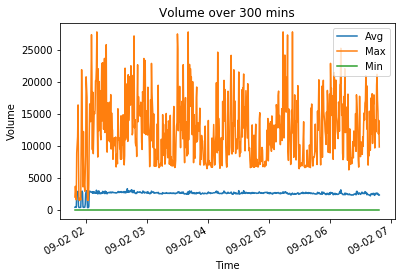

In [7]:
plt.plot(vToDate(audio[1:, 0]), audio[1:,1], label='Avg')
plt.plot(vToDate(audio[1:, 0]), audio[1:,2], label='Max')
plt.plot(vToDate(audio[1:, 0]), audio[1:,3], label='Min')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title(f"Volume over {audio_run_time} mins")
plt.gcf().autofmt_xdate()

We will graph the average volume with the temperature readings

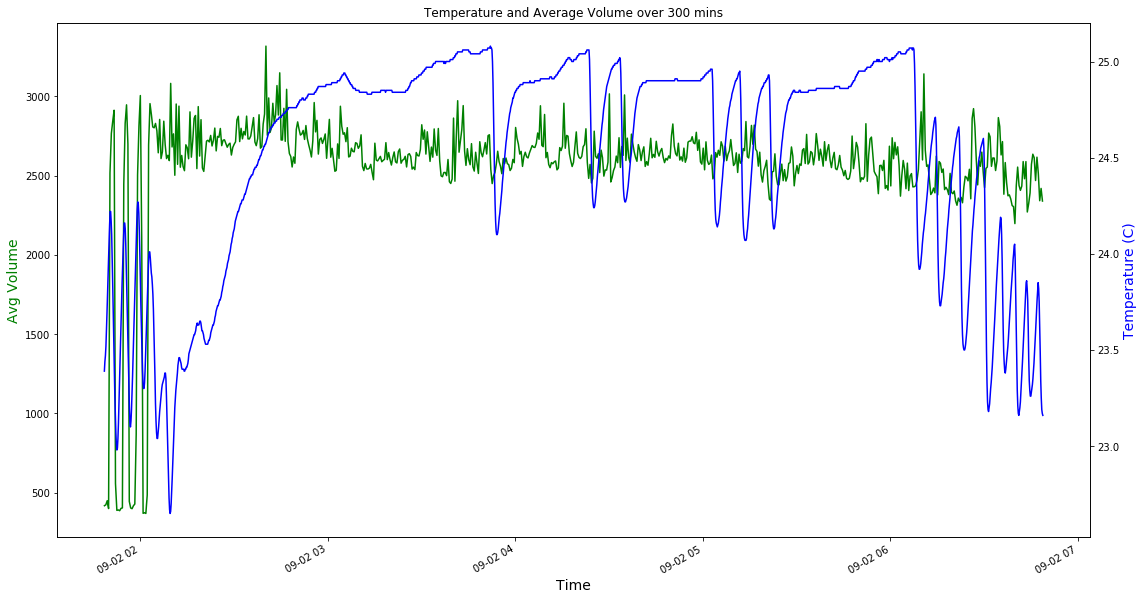

In [8]:
fig,ax = plt.subplots()
ax.plot(vToDate(audio[1:, 0]), audio[1:,1], color="green", label='Avg')
ax.set_title(f"Temperature and Average Volume over {longer_run_time} mins")
ax.set_xlabel("Time",fontsize=14)
ax.set_ylabel("Avg Volume",color="green",fontsize=14)

ax2=ax.twinx()
ax2.plot(vToDate(temp[1:, 0]), temp[1:,1], color="blue")
ax2.set_ylabel("Temperature (C)",color="blue",fontsize=14)
plt.gcf().autofmt_xdate()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

### Let's check which audio files and their timestamps have the AC on using the trained AI model  
Recall the `AC AI.ipynb` notebook trained an audio model to detect different urban noises. We will use that same model to examine the validity of when the AC was on by cross referencing the evaluation of each audio file with the graphs above. If an audio file includes AC sounds, then that portion of time of the audio file will be highlighted in red on the graph above.   
Three things worth mentioning:
1. The accuracy of the highlighted portions that indicate an AC was on is only as good as the duration of each audio clip. The smaller the sample duration, the more precise estimate of the time the AC was on.
2. The scale of accuracy is also be dictated by changing the percentage threshold required for an audio clip to be considered for having an AC on. The AI model calculates its own percentage when scanning the samples. 
3. The amount of time it takes to classify the audio files is dependent on the size of the `audio_samples` directory. 
 1. For reference, it took ~30 minutes to classify 980 MB worth of audio clips

In [9]:
import os
import re
from pyAudioAnalysis import audioTrainTest as aT
import matplotlib.patches as mpatches

In [11]:
# traverses the "audio_samples/" directory, checking if each audio file has AC sounds
# stores the timestamps of when the AC was on or off in seperate arrays

directory = "collected_data/audio_samples/"
pattern = r'\d+'
percentage_threshold = 0.96
timestamps_ac_on = []
timestamps_ac_off = []
for file in os.listdir(directory):
    class_id, probability, classes = aT.file_classification(directory + file, "urbanSounds", "svm")
    time = toDate(int(re.findall(pattern, file)[0]))
    
    if class_id == 0 and probability[0] > percentage_threshold:
        timestamps_ac_on.append(time)
    else:
        timestamps_ac_off.append(time)
    
    # os.unlink(directory + file) # optional to delete created audio files
    
print(f"number of ac_on clips: {len(timestamps_ac_on)}")
print(f"number of ac_off clips: {len(timestamps_ac_off)}")

number of ac_on clips: 680
number of ac_off clips: 1


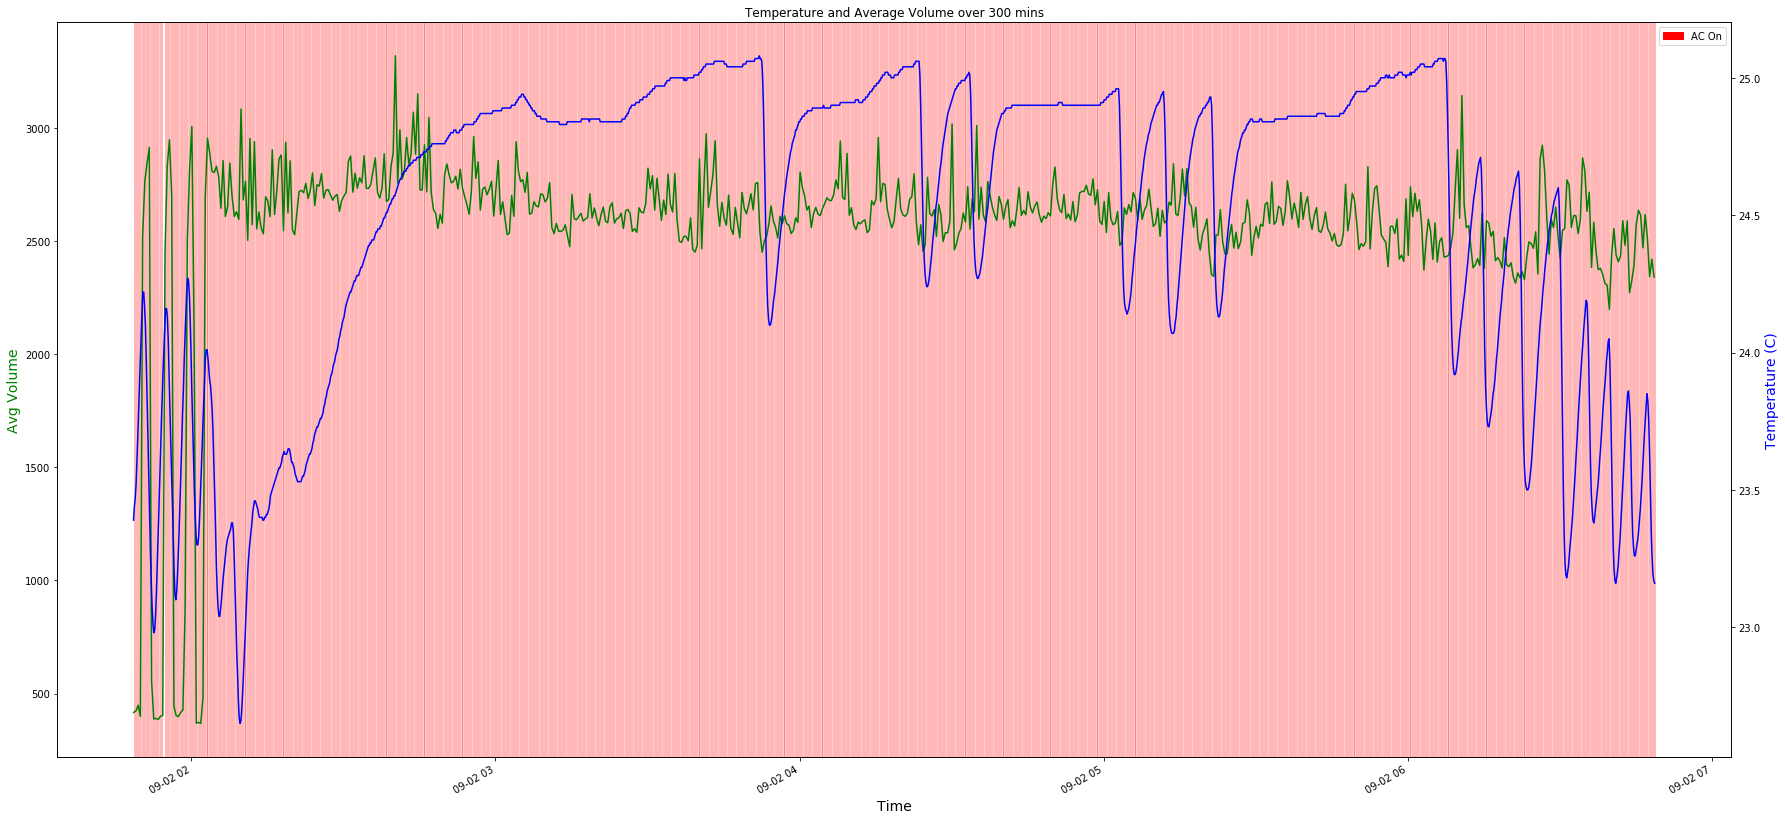

In [12]:
# labels the locations on the graph where the AI model considers there was an AC on

red_patch = mpatches.Patch(color='red', label='AC On')
ax.legend(handles=[red_patch])
    
for event in timestamps_ac_on:
    end = event + datetime.timedelta(seconds=vol_duration)
    ax.axvspan(event, end, color='red', alpha=0.2)
        

fig.set_size_inches(30, 15, forward=True)
fig.savefig(f'collected_data/temp_vol_{longer_run_time}mins.png', dpi=100)
    
fig